In [ ]:
!pip install --upgrade pip
!pip install -Uqq duckduckgo_search
!pip install ipywidgets
!pip install voila
!jupyter serverextension enable --sys-prefix voila

from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from time import sleep

In [2]:
def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [3]:
urls = search_images('strawberry', max_images=1)
urls[0]

'https://www.appleandgrape.com.au/wp-content/uploads/2020/11/strawberries.jpg'

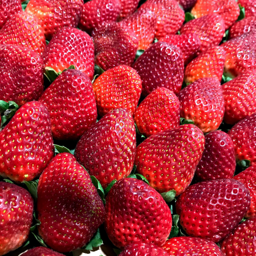

In [27]:
dest = 'strawberry.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256,256)

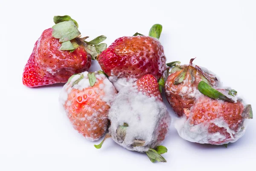

In [5]:
download_url(search_images('spoiled strawberry', max_images=1)[0], 'spoiled_strawberry.jpg', show_progress=False)
Image.open('spoiled_strawberry.jpg').to_thumb(256,256)

In [6]:
searches = 'ripe', 'spoiled'
path = Path('ripe_or_spoiled')

for o in searches:
  dest = (path/o)
  dest.mkdir(exist_ok=True, parents=True)
  download_images(dest, urls=search_images(f'{o} strawberry fruit', 600))
  sleep(10)
  resize_images(path/o, max_size=400, dest=path/o)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

17

In [8]:
strawberrys = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(264)
)

In [9]:
dls = strawberrys.dataloaders(path)

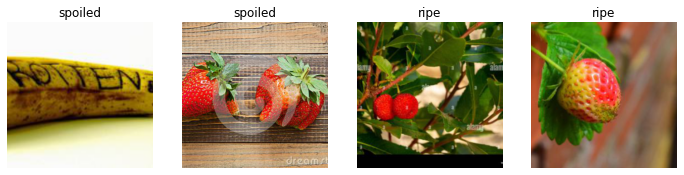

In [10]:
dls.valid.show_batch(max_n=4, nrows=1)

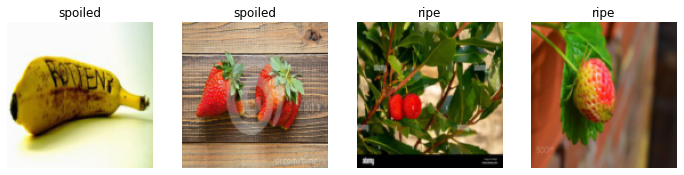

In [11]:
strawberrys = strawberrys.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = strawberrys.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

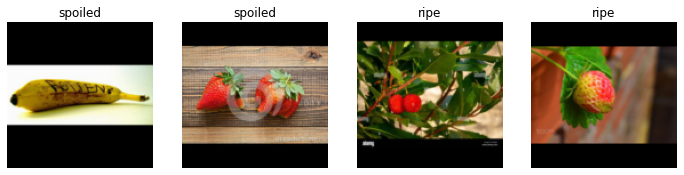

In [12]:
strawberrys = strawberrys.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = strawberrys.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

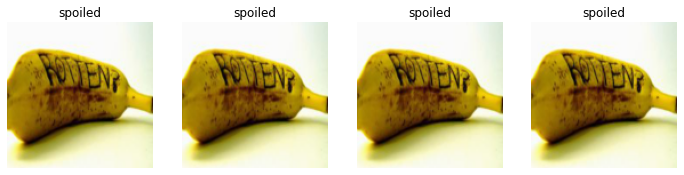

In [13]:
strawberrys = strawberrys.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = strawberrys.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1, unique=True)

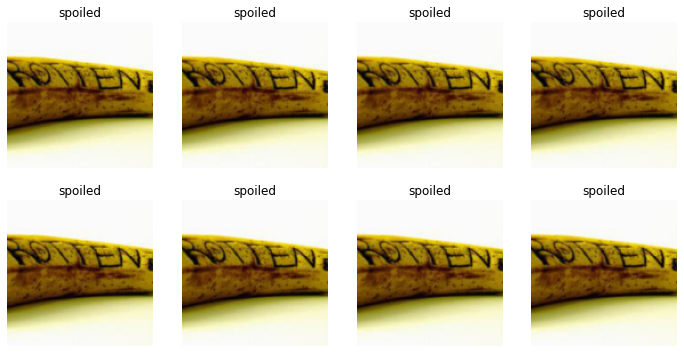

In [14]:
strawberrys = strawberrys.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = strawberrys.dataloaders(path)
dls.valid.show_batch(max_n=8, nrows=2, unique=True)

In [15]:
strawberrys = strawberrys.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = strawberrys.dataloaders(path)

In [16]:
learn = vision_learner(dls, resnet18, metrics=[error_rate, accuracy])
learn.fine_tune(10)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.022438,0.735079,0.273196,0.726804,00:08


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.815112,0.669088,0.278351,0.721649,00:05
1,0.734350,0.632010,0.283505,0.716495,00:05
2,0.678859,0.677650,0.278351,0.721649,00:05
3,0.592167,0.674137,0.252577,0.747423,00:05
4,0.518657,0.770770,0.262887,0.737113,00:05
5,0.456635,0.816994,0.288660,0.711340,00:04
6,0.401915,0.806785,0.247423,0.752577,00:05
7,0.352836,0.790607,0.237113,0.762887,00:04
8,0.316071,0.798236,0.231959,0.768041,00:04
9,0.280641,0.787278,0.231959,0.768041,00:04


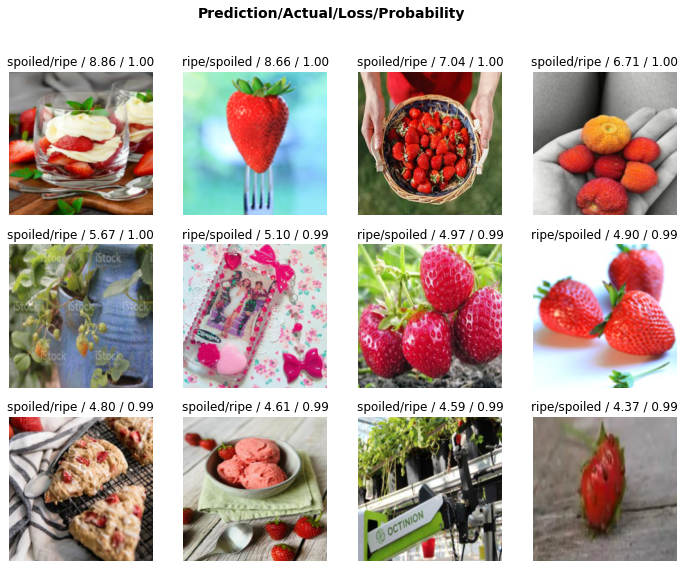

In [17]:
Learning_interpreter = ClassificationInterpretation.from_learner(learn)

Learning_interpreter.plot_top_losses(12)

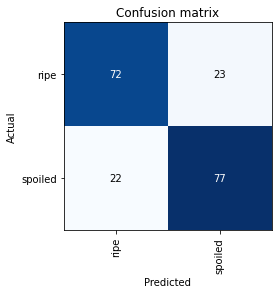

In [18]:
Learning_interpreter.plot_confusion_matrix()

In [19]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

In [20]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [21]:
is_spoiled_or_ripe,_,probs = learn.predict(PILImage.create('strawberry.jpg'))
print(f'this is a: {is_spoiled_or_ripe}.')
print(f"Probability it's a ripe: {probs[0]:.4f}")
print(f"Probability it's a spoiled: {probs[1]:.4f}")

this is a: ripe.
Probability it's a ripe: 0.6374
Probability it's a spoiled: 0.3626


In [22]:
learn.export()

In [23]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [24]:
learn_inf = load_learner(path/'export.pkl')

In [29]:
learn_inf.predict('strawberry.jpg')

('ripe', TensorBase(0), TensorBase([0.6374, 0.3626]))

In [30]:
learn_inf.dls.vocab

['ripe', 'spoiled']

In [31]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [32]:
btn_upload = SimpleNamespace(data = ['strawberry.jpg'])

In [35]:
img = PILImage.create(btn_upload.data[-1])

In [34]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(256,256))
out_pl

Output()

In [36]:
pred, pred_idx,probs = learn_inf.predict(img)

In [38]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Predition: {pred}; Probability:{probs[pred_idx]:.04f}'
lbl_pred

Label(value='Predition: ripe; Probability:0.6374')

In [39]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [41]:
def on_click_classify(change):
  img = PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl: display(img.to_thumb(256,256))
  pred,pred_idx,probs = learn_inf.predict(img)
  lbl_pred.value = f'Predition: {pred}; Probability:{probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [42]:
btn_upload = widgets.FileUpload()

In [50]:
from ipywidgets import VBox

VBox([widgets.Label('Select your Strawberry!'), btn_upload, btn_run, out_pl, lbl_pred])